In [1]:
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics as m
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns

Read the data
===========

In [2]:
x_original=pd.read_csv('../XLable_onlyDiabeticRemoved.txt')
y_original=pd.read_csv('../TargetLable_onlyDiabeticRemoved.txt')

# x_original=pd.read_csv('../_xlable4_withNa_AllColumns.txt')
# y_original=pd.read_csv('../_targelable4_withNa_AllColumns.txt')

y_original=y_original[['Unnamed: 0','S000300']]

Prepare the data
============

In [3]:
data= pd.merge(x_original,y_original, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')
 
#combine FIELD_6 and FIELD_7 both represent the same thing (Women's marital status)
data['max']=np.min(data[['FIELD_6','FIELD_7']],axis=1)
data=data.drop(columns=['FIELD_6','FIELD_7','B_DAY'])
print(data.shape)

(185843, 407)


In [4]:
# filter the data set 
data=data[data.FIELD_16!=1] # exclude people who are diagnosed for (diabetes) 
data=data[data.FIELD_23!=1] # exclude people who are on medication for diabetes

data=data[data.FIELD_15!=1] # exclude people who are diagnosed for (high blood pressure)
data=data[data.FIELD_22!=1] # exclude people who are on medication for high blood pressure

data=data[data.FIELD_17!=1] # exclude people who are diagnosed for hyperlipidemia
data=data[data.FIELD_24!=1] # exclude people who are on medication for hyperlipidemia

print(data.shape)

(169024, 407)


In [6]:
mydata=data[['S000300_y','S000300_x', 'L103300', 'S000501', 'L100700', 'SEX', 'L103100', 'L190300', 'L190400', 
             'L101300', 'S000502', 'L190500', 'L103000']].dropna() 

print(mydata.shape)

mydata.head()

(136531, 13)


,S000300_y,S000300_x,L103300,S000501,L100700,SEX,L103100,L190300,L190400,L101300,S000502,L190500,L103000
0,19.7,20.1,3.1,121.0,3.0,1.0,68.0,4.20,12.3,8.0,67.0,38.2,53.0
1,20.2,19.7,3.3,117.0,3.0,1.0,71.0,4.24,13.1,9.0,76.0,39.0,53.0
2,21.0,20.2,3.4,135.0,3.8,1.0,72.0,4.26,12.9,10.0,82.0,38.4,41.0
3,24.8,24.7,3.1,112.0,4.1,1.0,51.0,4.20,13.2,20.0,70.0,39.9,80.0
4,25.5,24.8,2.8,118.0,3.7,1.0,64.0,4.20,13.5,12.0,71.0,40.3,58.0


In [7]:
# # mydata=np.log2(mydata).dropna()
# # mydata=np.power(mydata,0.03)

# # mydata.join(, how='outer')

# for i in mydata.columns:
#     if (i != 'L103000_y'):
#         print(i)
#         mydata['p_'+i]=np.power(mydata[i],0.5)
# #         mydata['l_'+i]=np.log2(mydata[i])

# mydata=mydata.dropna()

# print(mydata.shape)
# mydata.head()

In [8]:
x=mydata[['S000300_x', 'L103300', 'S000501', 'L100700', 'SEX', 'L103100', 'L190300', 'L190400', 
             'L101300', 'S000502', 'L190500', 'L103000']] 

# x=mydata.iloc[:,1:]
y=mydata[['S000300_y']]

In [9]:
# np.where(np.isnan(y))
y.head()

,S000300_y
0,19.7
1,20.2
2,21.0
3,24.8
4,25.5


Check the correlation of the selected feature with the independent variables
=====

In [10]:
temppd=pd.DataFrame(x)
temppd['y']=mydata.S000300_y 

corr = (temppd.corr())

,0,val
12,y,1.000000
0,S000300_x,0.889210
1,L103300,0.419374
2,S000501,0.409677
3,L100700,0.401433
4,SEX,0.376998
6,L190300,0.358384
5,L103100,0.358081
7,L190400,0.349945
8,L101300,0.341258


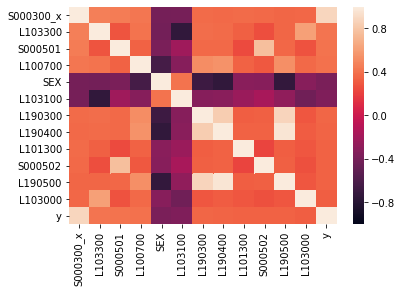

In [11]:
sns.heatmap(corr, vmin=-1, vmax=1)


corrpd=pd.DataFrame(corr.index)
corrpd['val']=abs(corr.y.values)
corrpd.sort_values(by='val', ascending=False).head(20)

Apply PCA
===========

In [12]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=4)
# pca.fit(x)

# print(pca.explained_variance_ratio_)   
# print(np.sum(pca.explained_variance_ratio_))

# x=pca.fit_transform(x) 
# print(x.shape)


feature scaling
=======

In [13]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()  #StandardScaler()
# x = min_max_scaler.fit_transform(x)

clustring test
==========

In [14]:
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cdist

# K = range(1,10)
# distortions = []

# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(x)
#     kmeanModel.fit(x)
#     distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()


In [15]:
# kmeanModel = KMeans(n_clusters=k).fit(x)
# x['lbl']=kmeanModel.labels_ 

Random Forest Regressor
=============

In [16]:
xtrain,xtest,ytrain,ytest=train_test_split(x, y, random_state=42, test_size=0.2)

In [17]:
regr = RandomForestRegressor(max_depth=7, random_state=0,verbose =0,n_estimators=50)
regr.fit(xtrain, ytrain) 
print(regr.feature_importances_)
ypred=regr.predict(xtest)


[3.31652983e-04 4.33098498e-04 7.67060320e-05 2.36038726e-04
 0.00000000e+00 6.12321698e-06 2.12934724e-04 8.62442281e-06
 3.83442416e-04 8.62495694e-04 1.90930692e-04 0.00000000e+00
 9.97257953e-01]


In [18]:
import math
print('mean_squared_error',m.mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(m.mean_squared_error(ytest, ypred)))
print('mean_absolute_error',m.mean_absolute_error(ytest, ypred))
print('r2_score',m.r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred 
ypredPD.tail(10)

mean_squared_error 0.13072464512993484
root mean_squared_error 0.36155863304578256
mean_absolute_error 0.019151319690529692
r2_score 0.9881696095686117


,t + 1,pred (t +1)
27297,23.1,23.100000
27298,19.1,19.101171
27299,25.9,25.899323
27300,25.0,24.983748
27301,22.5,22.500000
27302,23.4,23.400000
27303,21.7,21.700000
27304,19.9,19.896773
27305,23.8,23.800000
27306,17.8,17.820697


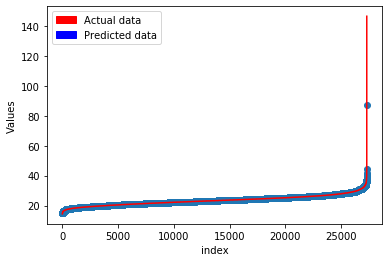

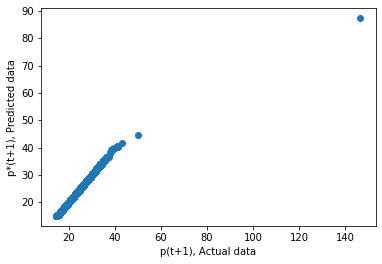

In [19]:
import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])


xg boost
==========

In [ ]:
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, 
#                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',max_depth = 10, alpha = 200, n_estimators = 50, 
                          booster='gbtree',
                          colsample_bytree = 0.6,learning_rate = 0.08,gamma=10, tree_method = 'gpu_hist'
                         )

xg_reg.fit(xtrain, ytrain) 

In [ ]:

ypred = xg_reg.predict(xtest)
 
print('mean_squared_error',m.mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(m.mean_squared_error(ytest, ypred)))
print('mean_absolute_error',m.mean_absolute_error(ytest, ypred))
print('r2_score',m.r2_score(ytest, ypred))


In [ ]:
import math
print('mean_squared_error',m.mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(m.mean_squared_error(ytest, ypred)))
print('mean_absolute_error',m.mean_absolute_error(ytest, ypred))
print('r2_score',m.r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)


In [ ]:

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.head(10)

ANN
==========

In [ ]:
model= Sequential()
model.add(Dense(input_dim=32,units=128,activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=128, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=16, activation='relu', kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=8, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=1, kernel_initializer='uniform'))
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_squared_error' ])

In [ ]:
h=model.fit(xtrain, ytrain, validation_split=.2,epochs=100, batch_size=50)

In [ ]:
ypred=model.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)

In [ ]:
history=h
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
ypredPD['diff']=abs(ypredPD['t + 1']- ypredPD['pred (t +1)'])
print(np.mean(ypredPD['diff']))
print(np.std(ypredPD['diff']))
print(100*ypredPD[ypredPD['diff']<=5].shape[0]/ypredPD.shape[0])

In [ ]:

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.head(10)

SVR
======

In [ ]:
from sklearn.svm import SVR
# svr_rbf = SVR(kernel='rbf', C=10, gamma=0.02, epsilon=.001)
svr_rbf = SVR(kernel='rbf')

In [ ]:
svr_rbf.fit(xtrain, ytrain) 

In [ ]:
ypred=svr_rbf.predict(xtest)

In [ ]:
import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)